In [ ]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

In [ ]:
fields = [StructField('label', IntegerType(), False)]
for i in range(1,29):
  for j in range(1,29):
    fields.append(StructField(str(i)+'x'+str(j),IntegerType(),True))
Schema = StructType(fields)

In [ ]:
test_set = spark.read.load("gs://week9buc/mnist_test.csv", format="csv", header=True, schema = Schema)
train_set = spark.read.load("gs://week9buc/mnist_train.csv", format="csv", header=True, schema = Schema)

In [ ]:
features = train_set.columns[1:]
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [ ]:
train_set = assembler.transform(train_set)
test_set = assembler.transform(test_set)

In [ ]:
model = DecisionTreeClassifier(featuresCol = 'features',
                               labelCol = 'label', predictionCol = 'prediction')
grid = ParamGridBuilder().addGrid(model.maxDepth, [4,8,12,16]).addGrid(model.maxBins, [2,4,8,16]).build()
cv = CrossValidator(estimator = model, estimatorParamMaps = grid,
                    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction"),
                    numFolds = 5)

In [ ]:
cvModel = cv.fit(train_set)

24/11/23 20:06:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/11/23 20:07:42 WARN DAGScheduler: Broadcasting large task binary with size 1219.1 KiB
24/11/23 20:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1108.4 KiB
24/11/23 20:07:51 WARN DAGScheduler: Broadcasting large task binary with size 1149.0 KiB
24/11/23 20:07:52 WARN DAGScheduler: Broadcasting large task binary with size 1039.0 KiB
24/11/23 20:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1170.9 KiB
24/11/23 20:08:04 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB
24/11/23 20:08:14 WARN DAGScheduler: Broadcasting large task binary with size 1009.5 KiB
24/11/23 20:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1154.0 KiB
24/11/23 20:08:18 WARN DAGScheduler: Broadcasting large task binary with size 1292.7 KiB
24/11/23 2

24/11/23 20:13:23 WARN DAGScheduler: Broadcasting large task binary with size 1293.5 KiB
24/11/23 20:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1344.5 KiB
24/11/23 20:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1400.5 KiB
24/11/23 20:13:26 WARN DAGScheduler: Broadcasting large task binary with size 1039.5 KiB
24/11/23 20:13:31 WARN DAGScheduler: Broadcasting large task binary with size 1000.4 KiB
24/11/23 20:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1237.8 KiB
24/11/23 20:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1482.7 KiB
24/11/23 20:13:33 WARN DAGScheduler: Broadcasting large task binary with size 1704.6 KiB
24/11/23 20:13:33 WARN DAGScheduler: Broadcasting large task binary with size 1865.9 KiB
24/11/23 20:13:34 WARN DAGScheduler: Broadcasting large task binary with size 1968.0 KiB
24/11/23 20:13:34 WARN DAGScheduler: Broadcasting large task binary with size 1477.0 KiB
24/11/23 20:13:41 WAR

24/11/23 20:18:42 WARN DAGScheduler: Broadcasting large task binary with size 1176.7 KiB
24/11/23 20:18:43 WARN DAGScheduler: Broadcasting large task binary with size 1396.8 KiB
24/11/23 20:18:44 WARN DAGScheduler: Broadcasting large task binary with size 1590.4 KiB
24/11/23 20:18:44 WARN DAGScheduler: Broadcasting large task binary with size 1747.0 KiB
24/11/23 20:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1859.2 KiB
24/11/23 20:18:46 WARN DAGScheduler: Broadcasting large task binary with size 1405.9 KiB
24/11/23 20:18:55 WARN DAGScheduler: Broadcasting large task binary with size 1185.8 KiB
24/11/23 20:18:56 WARN DAGScheduler: Broadcasting large task binary with size 1385.7 KiB
24/11/23 20:18:58 WARN DAGScheduler: Broadcasting large task binary with size 1562.8 KiB
24/11/23 20:18:59 WARN DAGScheduler: Broadcasting large task binary with size 1713.6 KiB
24/11/23 20:19:00 WARN DAGScheduler: Broadcasting large task binary with size 1826.4 KiB
24/11/23 20:19:01 WAR

In [ ]:
est = cvModel.bestModel
print(f'Best tree depth {est.getMaxDepth()}, Best bin size {est.getMaxBins()}')

Best tree depth 16, Best bin size 4


In [ ]:
testresult = est.transform(test_set)

In [ ]:
print(f'Total test points {testresult.count()}')
wrong = testresult.where(testresult.label!=testresult.prediction)
print(f'Wrongly classified count {wrong.count()}')

Total test points 9999


24/11/23 20:19:51 WARN DAGScheduler: Broadcasting large task binary with size 1490.6 KiB


Wrongly classified count 1144


24/11/23 20:19:54 WARN DAGScheduler: Broadcasting large task binary with size 1494.2 KiB


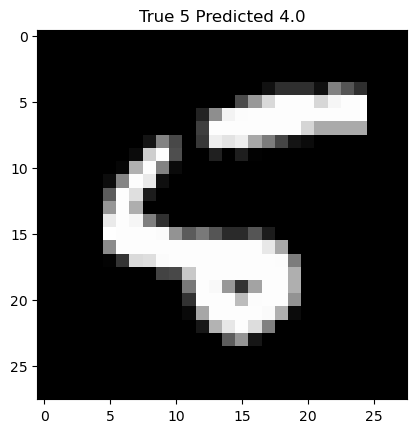

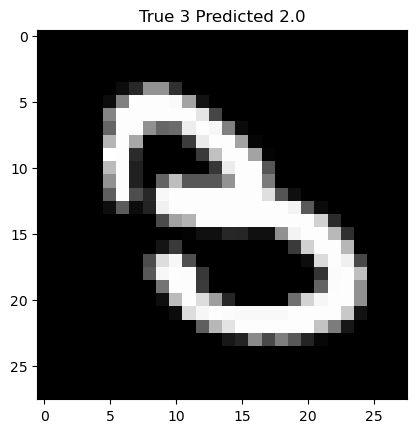

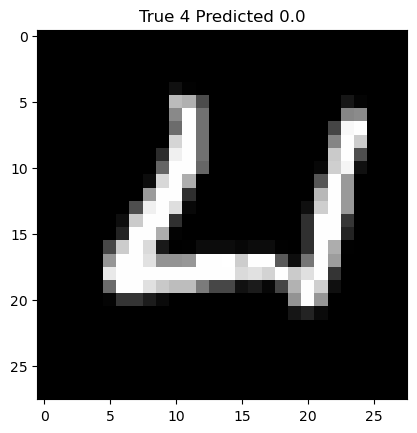

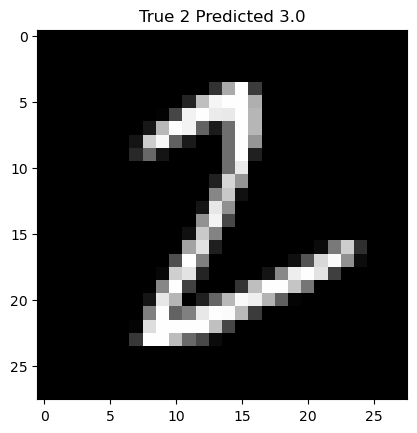

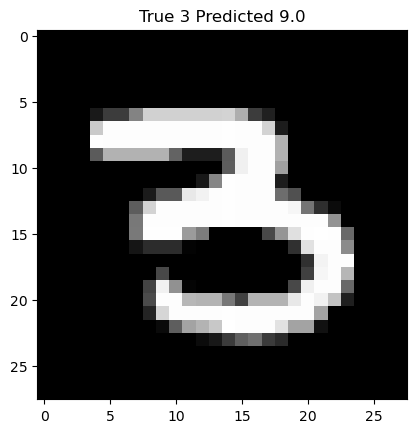

In [ ]:
temp = wrong.limit(5).select("label","prediction","features").collect()

for r in temp:
    plt.figure()
    row = np.array(r.features).reshape((28,28))
    plt.imshow(row,cmap = 'gray')
    plt.title(f'True {r.label} Predicted {r.prediction}')